In [171]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

In [172]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [173]:
# Loads the TSV file into a pandas DataFrame.
def load_data(file_path):
    df = pd.read_csv(file_path, sep='\t', header=None,
                     names=['label','file_name','label_text','statement','topic',
                            'speaker','speaker_job','state','party','barely_true_counts',
                            'false_counts','half_true_counts','mostly_true_counts',
                            'pants_on_fire_counts','venue','extracted_context'])
    return df

In [174]:
# Prints some basic information about the dataset.
def explore_data(df):
    print("Shape of DataFrame:", df.shape)
    print("\nData Types:\n", df.dtypes)
    print("\nNull values:\n",df.isnull().sum())
    print("\nFirst 5 rows:\n", df.head())


In [175]:
# Cleans the input text by removing special characters, lowercasing,
# tokenizing, removing stopwords, and applying lemmatization.
# I took most of it from my 2nd nlp hw
def preprocess_data(data):

    data['statement'] = data['statement'].fillna('')  # Fill empty values as string
    data['statement'] = data['statement'].str.lower()  # Convert to lowercase
    data['statement'] = data['statement'].apply(lambda x: re.sub(r'[^\w\s]', '', x))  # Remove punctuation
    data['statement'] = data['statement'].apply(lambda x: re.sub(r'\d+', '', x))  # Remove numbers

    # len(word) > 2 might be unncessary. Let's try
    data['statement'] = data['statement'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words and len(word) > 2]))  # Remove stopwords

    data['processed_statement'] = data['statement'].apply(lambda x: word_tokenize(x))    # Tokenize

    lemmatizer = WordNetLemmatizer()  # Initialize lemmatizer
    data['processed_statement'] = data['processed_statement'].apply(
        lambda token_list: [lemmatizer.lemmatize(word) for word in token_list])
    return data


In [176]:
# Plots the distribution of labels in the dataset (label_text column).
def plot_label_distribution(df):

    plt.figure(figsize=(8,4))
    sns.countplot(x='label_text', data=df, order=df['label_text'].value_counts().index)
    plt.title('Distribution of Label Text')
    plt.xlabel('Label Text')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [177]:
# Plots the distribution of 'party' column.
def plot_party_distribution(df):

    plt.figure(figsize=(8,4))
    sns.countplot(x='party', data=df, order=df['party'].value_counts().index)
    plt.title('Distribution of Party')
    plt.xlabel('Party')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [178]:
# Quite self explanatory name
def plot_top_15_speakers(df):

    top_speakers = df['speaker'].value_counts().head(15)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_speakers.index, y=top_speakers.values, palette="viridis")
    plt.xticks(rotation=45, ha='right')
    plt.title("Top 15 Speakers by Frequency")
    plt.xlabel("Speaker")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

In [179]:
# Plots a WordCloud of the most frequently used words in the statements.
def plot_wordcloud(df, column='statement'):

    text = " ".join(df[column].dropna().values)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [180]:
# Plots the truth label distribution for the top 4 speakers.
def plot_top_4_speakers_label_distribution(df):
    # Get top 4 speakers by number of statements
    top_4_speakers = df['speaker'].value_counts().head(4).index

    # Filter rows for top 4 speakers
    df_top_4 = df[df['speaker'].isin(top_4_speakers)]

    # Group by
    group_df = df_top_4.groupby(['speaker', 'label_text']).size().reset_index(name='count')

    # Create pivot table
    pivot_table = group_df.pivot(index='speaker', columns='label_text', values='count').fillna(0)

    # Reorder columns from most true to most false
    ordered_labels = ['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire']
    pivot_table = pivot_table[ordered_labels]

    # Plot settings
    plt.figure(figsize=(10, 6))

    pivot_table.plot(kind='bar', stacked=False, ax=plt.gca())

    plt.title("Label Distribution for Top 4 Speakers")
    plt.xlabel("Speaker")
    plt.ylabel("Count of Labels")
    plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [181]:
# Correlation of most used words and labels
def plot_word_label_correlation(df):
    # Get most common words
    all_words = [word for statement in df['processed_statement'] for word in statement]
    word_freq = pd.Series(all_words).value_counts()
    top_words = word_freq.head(15).index.tolist()

    # Create word presence matrix
    word_matrices = []
    for word in top_words:
        word_matrices.append(df['processed_statement'].apply(lambda x: word in x).astype(int))

    word_df = pd.concat(word_matrices, axis=1)
    word_df.columns = top_words

    # Calculate correlations
    label_dummies = pd.get_dummies(df['label_text'])
    correlation_matrix = pd.DataFrame()
    ordered_labels = ['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire']

    for label in ordered_labels:
        correlation_matrix[label] = word_df.corrwith(label_dummies[label])

    # Plot
    plt.figure(figsize=(12, 6))
    sns.heatmap(correlation_matrix.T,
                cmap='Blues',
                annot=True,
                fmt='.2f',
                xticklabels=top_words,
                yticklabels=ordered_labels,
                cbar_kws={'label': ''})

    plt.title('Token-Label Distribution')
    plt.xlabel('Token')
    plt.ylabel('Label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [182]:
train_df = load_data('dataset/train2.tsv')
val_df = load_data('dataset/val2.tsv')
test_df = load_data('dataset/test2.tsv')

print("\n--------------------------  Attention! Training dataset incoming!  ---------------------------\n")
explore_data(train_df)
print("\n--------------------------  Attention! Validation dataset incoming!  ---------------------------\n")
explore_data(val_df)
print("\n--------------------------  Attention! Test dataset incoming!  ---------------------------\n")
explore_data(test_df)


--------------------------  Attention! Training dataset incoming!  ---------------------------

Shape of DataFrame: (10240, 16)

Data Types:
 label                     int64
file_name                object
label_text               object
statement                object
topic                    object
speaker                  object
speaker_job              object
state                    object
party                    object
barely_true_counts      float64
false_counts            float64
half_true_counts        float64
mostly_true_counts      float64
pants_on_fire_counts    float64
venue                    object
extracted_context        object
dtype: object

Null values:
 label                      0
file_name                  0
label_text                 0
statement                  0
topic                      2
speaker                    2
speaker_job             2898
state                   2210
party                      2
barely_true_counts         2
false_counts              

In [183]:
# There are 2 null values for speaker in the training data. Here we drop them
print("Before: ", train_df['speaker'].isnull().sum())
train_df = train_df.dropna(subset=['speaker'])
print("After: ", train_df['speaker'].isnull().sum())

Before:  2
After:  0


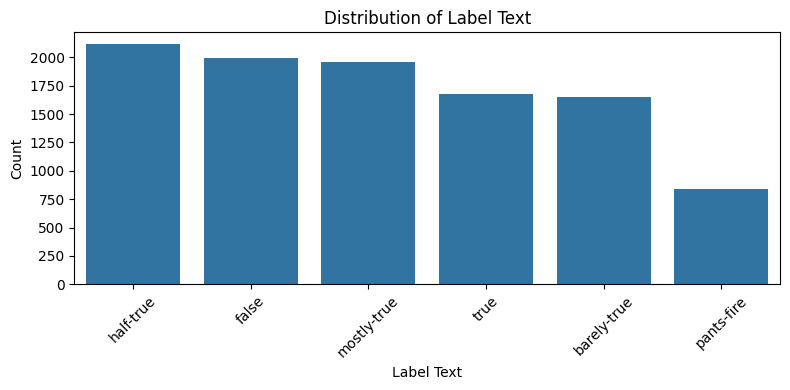

In [184]:
plot_label_distribution(train_df)

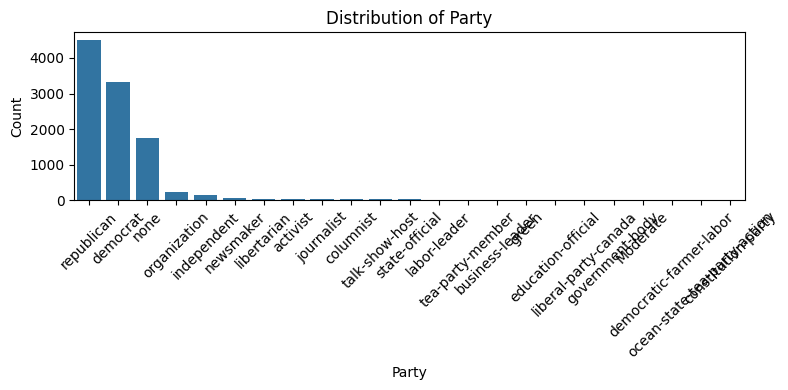

In [185]:
plot_party_distribution(train_df)

<ipython-input-178-9955f1f81154>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_speakers.index, y=top_speakers.values, palette="viridis")


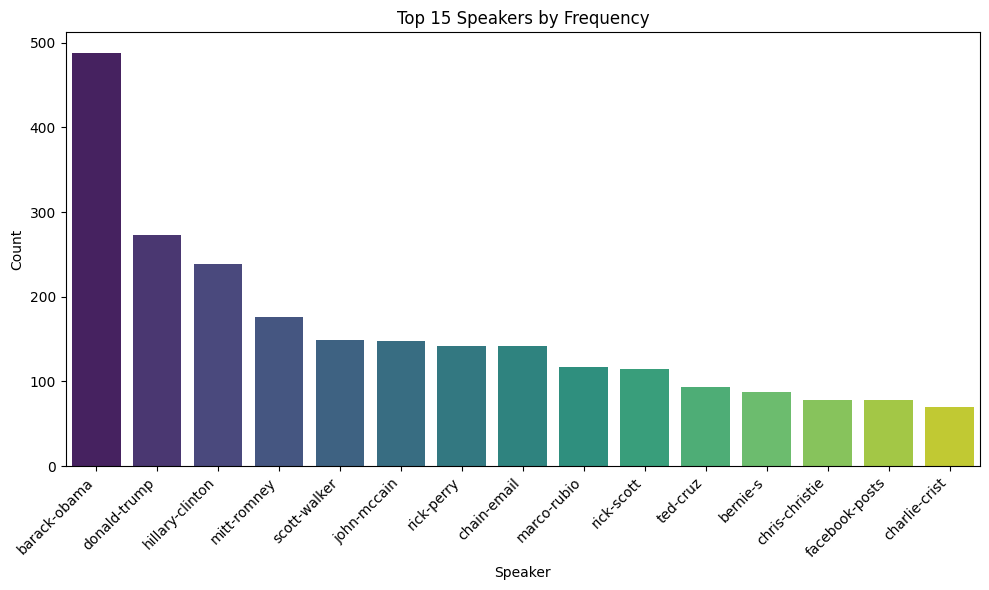

In [186]:
plot_top_15_speakers(train_df)

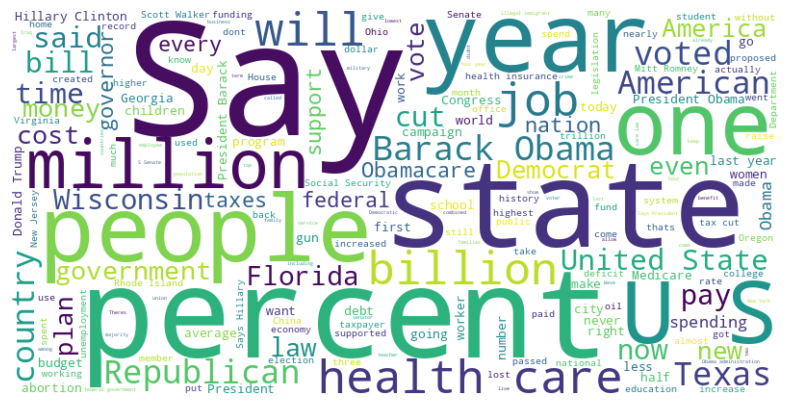

In [187]:
plot_wordcloud(train_df)

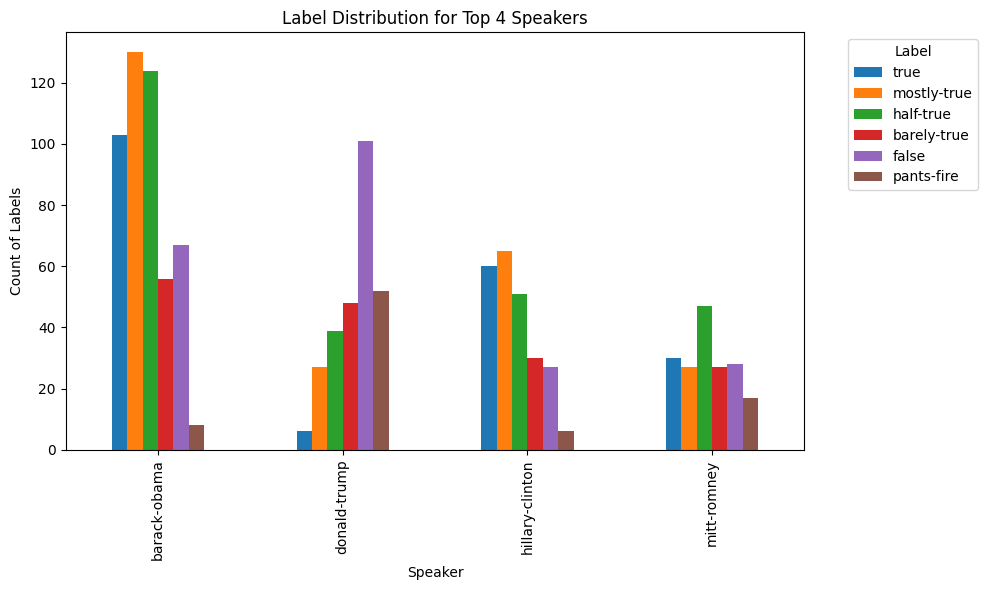

In [188]:
plot_top_4_speakers_label_distribution(train_df)

In [189]:
# Text preprocessing:
train_df = preprocess_data(train_df)
val_df = preprocess_data(val_df)
test_df = preprocess_data(test_df)
train_df["processed_statement"]


,processed_statement
0,"[say, annies, list, political, group, support,..."
1,"[decline, coal, start, started, natural, gas, ..."
2,"[hillary, clinton, agrees, john, mccain, votin..."
3,"[health, care, reform, legislation, likely, ma..."
4,"[economic, turnaround, started, end, term]"
...,...
10235,"[larger, number, shark, attack, florida, case,..."
10236,"[democrat, become, party, atlanta, metro, area..."
10237,"[say, alternative, social, security, operates,..."
10238,"[lifting, cuban, embargo, allowing, travel, cuba]"


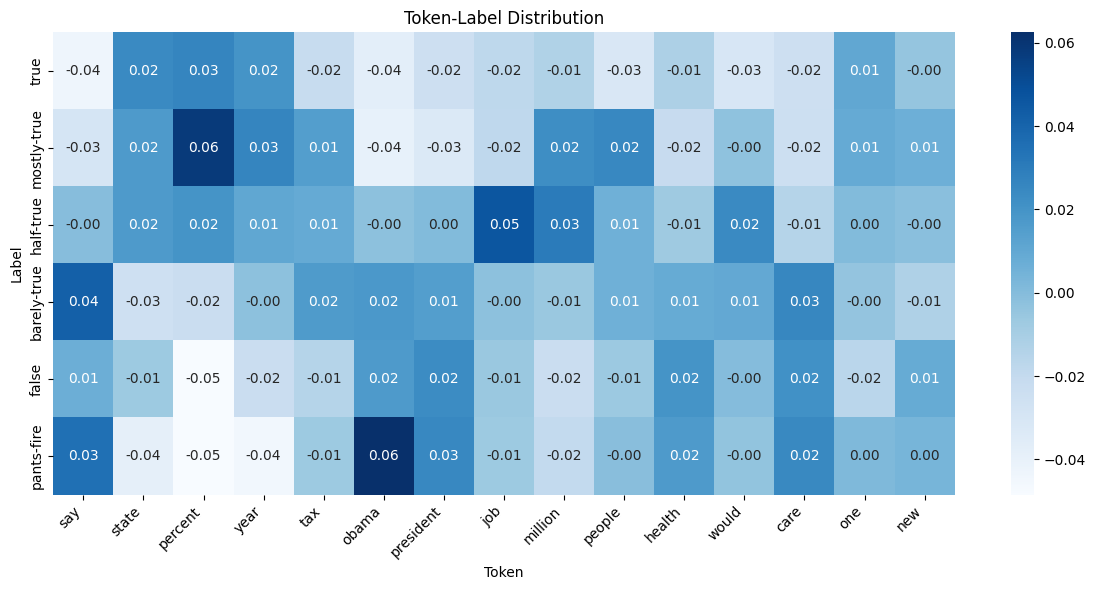

In [190]:
plot_word_label_correlation(train_df)